Full-Patient Analysis

In [1]:
# Import Modules
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import Actigraph_Metrics
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, skew, ttest_rel

c:\Users\sidha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\sidha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:59: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Accelerometry Normalization

In [2]:
data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'
window_size = 100  # 100 is 1 second worth of time
lead_time = 15
slice_size_min = 16
sr = 0.5

# Initialize lists to store full dataset
all_x_mag_norm = []
all_sbs = []
total_sbs_scores = 0

for patient in os.listdir(data_dir):
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        print(f'Processing {patient}...')
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MINNurse.mat')
        data = loadmat(data_filepath)
        
        x_mag = data["x_mag"]
        SBS = data["sbs"].flatten()
        print(x_mag.shape)
        overall_min = np.min(x_mag)
        overall_max = np.max(x_mag)
        
        # Normalize x_mag
        x_mag_norm = (x_mag - overall_min) / (overall_max - overall_min)
        all_x_mag_norm.append(x_mag_norm)
        all_sbs.extend(SBS)
        total_sbs_scores += len(SBS)

# concatenate x_mag_norm arrays
all_x_mag_norm = np.vstack(all_x_mag_norm)
all_sbs = np.array(all_sbs)

print(f'Full patient dataset complete: {total_sbs_scores} SBS scores')
print(f'Shape of x_mag_norm: {all_x_mag_norm.shape}')
print(f'Shape of SBS: {all_sbs.shape}')

all_accel = {'x_mag_norm': all_x_mag_norm, 'SBS': all_sbs}

Processing Patient11...
(14, 95999)
Processing Patient12...
(6, 95999)
Processing Patient13...
(31, 95999)
Processing Patient2...
(30, 95999)
Processing Patient3...
(11, 95999)
Processing Patient4...
(114, 95999)
Processing Patient5...
(39, 95999)
Processing Patient8...
(4, 95999)
Processing Patient9...
(60, 95999)
Full patient dataset complete: 309 SBS scores
Shape of x_mag_norm: (309, 95999)
Shape of SBS: (309,)


In [3]:
def MAD_boxplot(sbs, x_mag, window_size=100, show_outlier=True):
    # Accelerometry is at 100 Hz, so window_size = 100 means 1 second
    
    # Output Boxplot for each SBS Score
    sbs_mad_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
    sbs_skew_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
    sbs_stdev_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
    sbs_mean_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}


    # Populate the dictionary with MAD values
    for i, sbs_value in enumerate(sbs):    
        signal = Actigraph_Metrics.VecMag_MAD(x_mag[i,:], window_size)
        sbs_mad_dict[sbs_value].extend(signal)
        sbs_skew_dict[sbs_value].append(skew(signal, axis = 0, bias = True))
        sbs_stdev_dict[sbs_value].append(np.std(signal))
        sbs_mean_dict[sbs_value].append(np.mean(signal))
        
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Box plot: this version will show the outliers too
    ax[0,0].boxplot([sbs_mad_dict[-3], sbs_mad_dict[-2], sbs_mad_dict[-1], sbs_mad_dict[0], sbs_mad_dict[1], sbs_mad_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    ax[0,1].boxplot([sbs_skew_dict[-3], sbs_skew_dict[-2], sbs_skew_dict[-1], sbs_skew_dict[0], sbs_skew_dict[1], sbs_skew_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    ax[1,0].boxplot([sbs_stdev_dict[-3], sbs_stdev_dict[-2], sbs_stdev_dict[-1], sbs_stdev_dict[0], sbs_stdev_dict[1], sbs_stdev_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    ax[1,1].boxplot([sbs_mean_dict[-3], sbs_mean_dict[-2], sbs_mean_dict[-1], sbs_mean_dict[0], sbs_mean_dict[1], sbs_mean_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    #label axes
    ax[0,0].set_xlabel('SBS Score', fontsize = 8)
    ax[0,0].set_ylabel('MAD', fontsize = 8)
    ax[0,1].set_xlabel('SBS Score', fontsize = 8)
    ax[0,1].set_ylabel('Skew', fontsize = 8)
    ax[1,0].set_xlabel('SBS Score', fontsize = 8)
    ax[1,0].set_ylabel('Mean', fontsize = 8)
    ax[1,1].set_xlabel('SBS Score', fontsize = 8)
    ax[1,1].set_ylabel('Standard Deviation', fontsize = 8)
    fig.suptitle('Combined Patient Boxplots (Total 9 Patients)', fontsize=16)

    # Perform independent t-test comparisons
    print("Comparison between SBS -1 and 2")
    t_stat_mad, p_value_mad = ttest_ind(sbs_mean_dict[-1], sbs_mean_dict[2], equal_var=False)
    print("T-statistic:", t_stat_mad)
    print("P-value:", p_value_mad)
    
    print("Comparison between SBS -1 and 0")
    t_stat_mad, p_value_mad = ttest_ind(sbs_mean_dict[-1], sbs_mean_dict[0], equal_var=False)
    print("T-statistic:", t_stat_mad)
    print("P-value:", p_value_mad)
    
    print("Comparison between SBS 0 and 1")
    t_stat_mad, p_value_mad = ttest_ind(sbs_mean_dict[-1], sbs_mean_dict[1], equal_var=False)
    print("T-statistic:", t_stat_mad)
    print("P-value:", p_value_mad)
    
    print("Comparison between SBS 1 and 2")
    t_stat_mad, p_value_mad = ttest_ind(sbs_mean_dict[1], sbs_mean_dict[2], equal_var=False)
    print("T-statistic:", t_stat_mad)
    print("P-value:", p_value_mad)

    return ax, sbs_mad_dict, sbs_mean_dict, sbs_stdev_dict, sbs_skew_dict

Comparison between SBS -1 and 2
T-statistic: -1.4818905729579248
P-value: 0.14211708916466914
Comparison between SBS -1 and 0
T-statistic: -2.2253607001483613
P-value: 0.027520876037097262
Comparison between SBS 0 and 1
T-statistic: -0.7030348334737608
P-value: 0.48341819197837754
Comparison between SBS 1 and 2
T-statistic: -0.9114466603326657
P-value: 0.3644345009352725


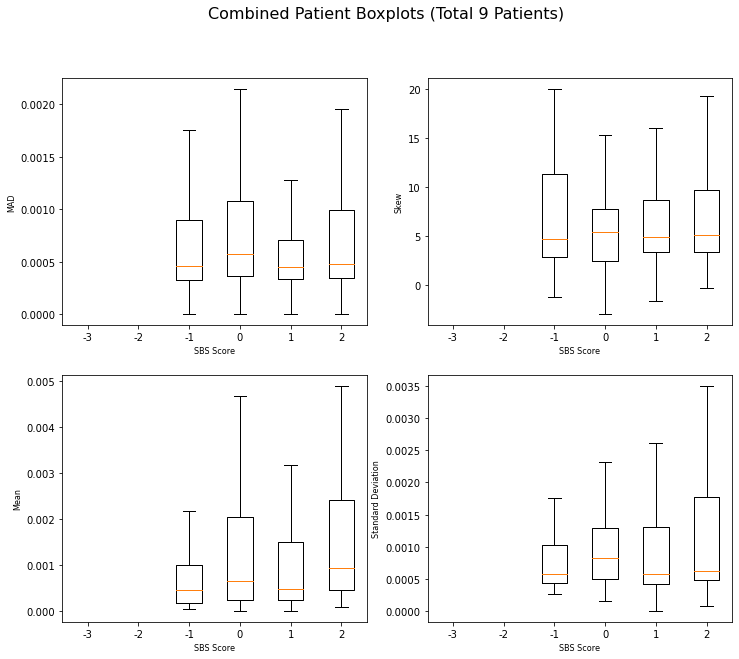

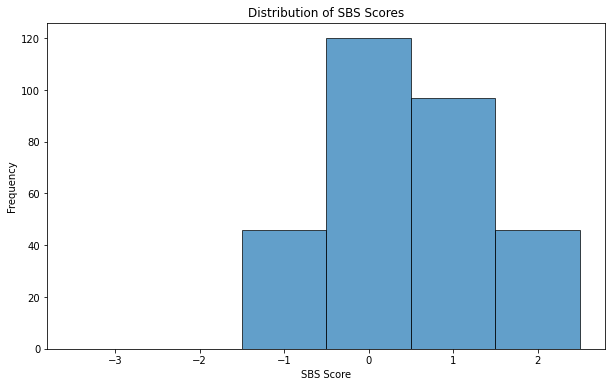

In [4]:
# Plot MAD Boxplots
MAD_boxplot(all_accel['SBS'], all_accel['x_mag_norm'], window_size, show_outlier=False)

# Plot distribution of sbs scores
plt.figure(figsize=(10, 6))
plt.hist(all_accel['SBS'], bins=np.arange(-3.5, 3.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel('SBS Score')
plt.ylabel('Frequency')
plt.title('Distribution of SBS Scores')
plt.xticks(ticks=np.arange(-3, 3, 1))
plt.show()

Vitals Normalization

In [6]:
# Initialize lists to store full dataset
all_heart_rate_norm = []
all_respiratory_rate_norm = []
all_SpO2_norm = []
all_sbs = []
total_sbs_scores = 0

for patient in os.listdir(data_dir):
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        print(f'Processing {patient}...')
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MINNurse.mat')
        data = loadmat(data_filepath)
        
        heart_rate = data["heart_rate"]
        respiratory_rate = data["respiratory_rate"]
        SpO2 = data["SpO2"]
        SBS = data["sbs"].flatten()
        print(heart_rate.shape, respiratory_rate.shape, SpO2.shape)
        
        # Normalize heart_rate
        hr_min = np.min(heart_rate)
        hr_max = np.max(heart_rate)
        heart_rate_norm = (heart_rate - hr_min) / (hr_max - hr_min)
        all_heart_rate_norm.append(heart_rate_norm)
        
        # Normalize respiratory_rate
        rr_min = np.min(respiratory_rate)
        rr_max = np.max(respiratory_rate)
        respiratory_rate_norm = (respiratory_rate - rr_min) / (rr_max - rr_min)
        all_respiratory_rate_norm.append(respiratory_rate_norm)
        
        # Normalize SpO2
        SpO2_min = np.min(SpO2)
        SpO2_max = np.max(SpO2)
        SpO2_norm = (SpO2 - SpO2_min) / (SpO2_max - SpO2_min)
        all_SpO2_norm.append(SpO2_norm)
        
        all_sbs.extend(SBS)
        total_sbs_scores += len(SBS)

# concatenate normalized arrays
all_heart_rate_norm = np.vstack(all_heart_rate_norm)
all_respiratory_rate_norm = np.vstack(all_respiratory_rate_norm)
all_SpO2_norm = np.vstack(all_SpO2_norm)
all_sbs = np.array(all_sbs)

print(f'Full patient dataset complete: {total_sbs_scores} SBS scores')
print(f'Shape of heart_rate_norm: {all_heart_rate_norm.shape}')
print(f'Shape of respiratory_rate_norm: {all_respiratory_rate_norm.shape}')
print(f'Shape of SpO2_norm: {all_SpO2_norm.shape}')
print(f'Shape of SBS: {all_sbs.shape}')

all_vitals = {
    'heart_rate_norm': all_heart_rate_norm,
    'respiratory_rate_norm': all_respiratory_rate_norm,
    'SpO2_norm': all_SpO2_norm,
    'SBS': all_sbs
}

Processing Patient11...
(14, 480) (14, 480) (14, 480)
Processing Patient12...
(6, 480) (6, 480) (6, 480)
Processing Patient13...
(31, 480) (31, 480) (31, 480)
Processing Patient2...
(30, 480) (30, 480) (30, 480)
Processing Patient3...
(11, 480) (11, 480) (11, 480)
Processing Patient4...
(114, 480) (114, 480) (114, 480)
Processing Patient5...
(39, 480) (39, 480) (39, 480)
Processing Patient8...
(4, 480) (4, 480) (4, 480)
Processing Patient9...
(60, 480) (60, 480) (60, 480)
Full patient dataset complete: 309 SBS scores
Shape of heart_rate_norm: (309, 480)
Shape of respiratory_rate_norm: (309, 480)
Shape of SpO2_norm: (309, 480)
Shape of SBS: (309,)


C:\Users\sidha\AppData\Local\Temp\ipykernel_5312\620319036.py:30: RuntimeWarning: invalid value encountered in true_divide
  respiratory_rate_norm = (respiratory_rate - rr_min) / (rr_max - rr_min)


In [10]:
def vitals_boxplot(sbs, vitals_signal, window_size=100, show_outlier=True):
    # Output Boxplot for each SBS Score
    sbs_skew_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
    sbs_stdev_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
    sbs_mean_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}


    # Populate the dictionary with MAD values
    for i, sbs_value in enumerate(sbs):    
        signal = vitals_signal[i]
        if np.mean(signal) !=0:
            sbs_skew_dict[sbs_value].append(skew(signal))
            sbs_stdev_dict[sbs_value].append(np.std(signal))
            sbs_mean_dict[sbs_value].append(np.mean(signal))
        else:
            print(f'not enough data at sbs index {i}, flag_list detected') #flag list was detected here. Note: If you go into matlab to cross-check, be aware matlab indices start at 1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    
    #Drop NaN Values
    sbs_skew_dict = {key: [x for x in value if not np.isnan(x)] for key, value in sbs_skew_dict.items()}
    sbs_stdev_dict = {key: [x for x in value if not np.isnan(x)] for key, value in sbs_stdev_dict.items()}
    sbs_mean_dict = {key: [x for x in value if not np.isnan(x)] for key, value in sbs_mean_dict.items()}
    
    # Box plot: this version will show the outliers too
    ax[1].boxplot([sbs_skew_dict[-3], sbs_skew_dict[-2], sbs_skew_dict[-1], sbs_skew_dict[0], sbs_skew_dict[1], sbs_skew_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    ax[0].boxplot([sbs_stdev_dict[-3], sbs_stdev_dict[-2], sbs_stdev_dict[-1], sbs_stdev_dict[0], sbs_stdev_dict[1], sbs_stdev_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)
    ax[2].boxplot([sbs_mean_dict[-3], sbs_mean_dict[-2], sbs_mean_dict[-1], sbs_mean_dict[0], sbs_mean_dict[1], sbs_mean_dict[2]], 
                    labels=['-3','-2', '-1', '0', '1', '2'], showfliers=show_outlier)

    #label axes
    ax[0].set_xlabel('SBS Score', fontsize = 10)
    ax[0].set_ylabel('Stdev', fontsize = 10)
    ax[2].set_xlabel('SBS Score', fontsize = 10)
    ax[2].set_ylabel('Mean', fontsize = 10)
    ax[1].set_xlabel('SBS Score', fontsize = 10)
    ax[1].set_ylabel('Skew', fontsize = 10)
    return ax, sbs_mean_dict, sbs_stdev_dict, sbs_skew_dict

not enough data at sbs index 27, flag_list detected
not enough data at sbs index 36, flag_list detected
not enough data at sbs index 51, flag_list detected
not enough data at sbs index 74, flag_list detected
not enough data at sbs index 75, flag_list detected
not enough data at sbs index 76, flag_list detected
not enough data at sbs index 78, flag_list detected
not enough data at sbs index 89, flag_list detected
not enough data at sbs index 92, flag_list detected
not enough data at sbs index 101, flag_list detected
not enough data at sbs index 136, flag_list detected
not enough data at sbs index 137, flag_list detected
not enough data at sbs index 162, flag_list detected
not enough data at sbs index 166, flag_list detected
not enough data at sbs index 167, flag_list detected
not enough data at sbs index 200, flag_list detected
not enough data at sbs index 223, flag_list detected
not enough data at sbs index 249, flag_list detected
not enough data at sbs index 263, flag_list detected
no

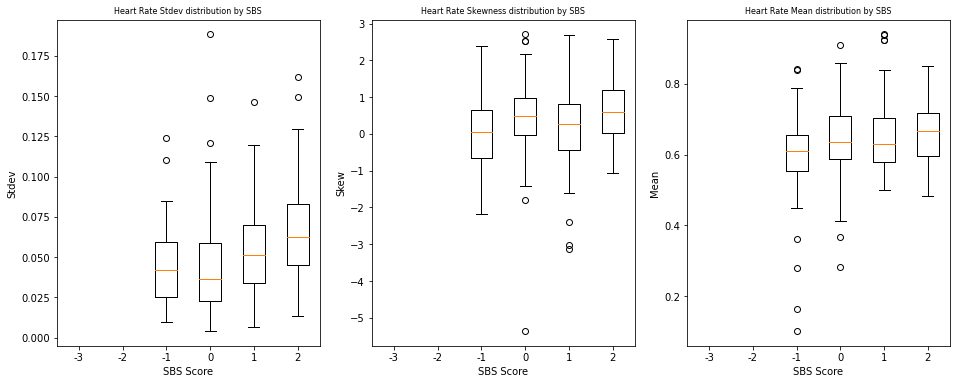

not enough data at sbs index 20, flag_list detected
not enough data at sbs index 24, flag_list detected
not enough data at sbs index 27, flag_list detected
not enough data at sbs index 28, flag_list detected
not enough data at sbs index 31, flag_list detected
not enough data at sbs index 36, flag_list detected
not enough data at sbs index 38, flag_list detected
not enough data at sbs index 40, flag_list detected
not enough data at sbs index 42, flag_list detected
not enough data at sbs index 44, flag_list detected
not enough data at sbs index 45, flag_list detected
not enough data at sbs index 47, flag_list detected
not enough data at sbs index 48, flag_list detected
not enough data at sbs index 49, flag_list detected
not enough data at sbs index 50, flag_list detected
not enough data at sbs index 51, flag_list detected
not enough data at sbs index 54, flag_list detected
not enough data at sbs index 55, flag_list detected
not enough data at sbs index 56, flag_list detected
not enough d

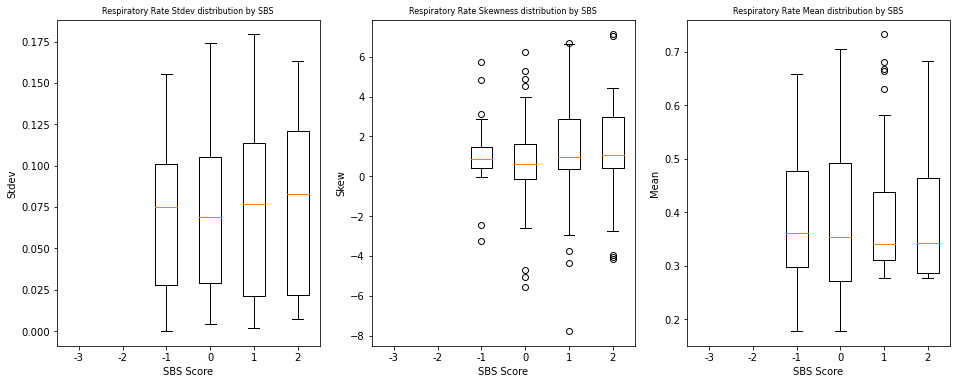

not enough data at sbs index 23, flag_list detected
not enough data at sbs index 27, flag_list detected
not enough data at sbs index 36, flag_list detected
not enough data at sbs index 42, flag_list detected
not enough data at sbs index 49, flag_list detected
not enough data at sbs index 51, flag_list detected
not enough data at sbs index 55, flag_list detected
not enough data at sbs index 58, flag_list detected
not enough data at sbs index 78, flag_list detected
not enough data at sbs index 89, flag_list detected
not enough data at sbs index 92, flag_list detected
not enough data at sbs index 101, flag_list detected
not enough data at sbs index 106, flag_list detected
not enough data at sbs index 117, flag_list detected
not enough data at sbs index 140, flag_list detected
not enough data at sbs index 162, flag_list detected
not enough data at sbs index 167, flag_list detected
not enough data at sbs index 168, flag_list detected
not enough data at sbs index 170, flag_list detected
not 

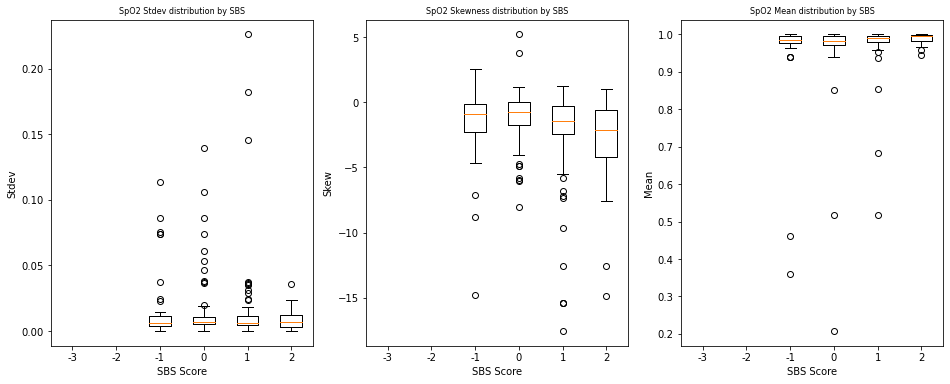

In [11]:
ax2, sbs_mean_dict, sbs_stdev_dict, sbs_skew_dict = vitals_boxplot(all_vitals['SBS'], all_vitals['heart_rate_norm'], window_size, show_outlier=True) #boxplot function iterates through 2D array
ax2[0].set_title(f'Heart Rate Stdev distribution by SBS', fontsize = 8)
ax2[1].set_title(f'Heart Rate Skewness distribution by SBS', fontsize = 8)
ax2[2].set_title(f'Heart Rate Mean distribution by SBS', fontsize = 8)
plt.show()

ax1, sbs_mean_dict, sbs_stdev_dict, sbs_skew_dict = vitals_boxplot(all_vitals['SBS'], all_vitals['respiratory_rate_norm'], window_size, show_outlier=True) #boxplot function iterates through 2D array
ax1[0].set_title(f'Respiratory Rate Stdev distribution by SBS', fontsize = 8)
ax1[1].set_title(f'Respiratory Rate Skewness distribution by SBS', fontsize = 8)
ax1[2].set_title(f'Respiratory Rate Mean distribution by SBS', fontsize = 8)
plt.show()

ax1, sbs_mean_dict, sbs_stdev_dict, sbs_skew_dict = vitals_boxplot(all_vitals['SBS'], all_vitals['SpO2_norm'], window_size, show_outlier=True) #boxplot function iterates through 2D array
ax1[0].set_title(f'SpO2 Stdev distribution by SBS', fontsize = 8)
ax1[1].set_title(f'SpO2 Skewness distribution by SBS', fontsize = 8)
ax1[2].set_title(f'SpO2 Mean distribution by SBS', fontsize = 8)
plt.show()